In [18]:
import import_ipynb
import numpy as np
import h5py
import torch
from angle_encoding_script import angle_encoding
from haar_noising_script import apply_haar_scrambling

filename = "C:/Users/realc/OneDrive/Documents/GSOC/data/QG1_normalized_16_xl"
data_X = np.array(h5py.File(filename, "r")['X'])

num_samples = 10000

encoded_data = [angle_encoding(data_X, sample) for sample in range(num_samples)]
encoded_data = torch.tensor(np.array(encoded_data), dtype=torch.float32)
print(encoded_data.shape)

scrambled_states = apply_haar_scrambling(np.array(encoded_data), num_samples, seed=42)
scrambled_states = torch.tensor(scrambled_states, dtype=torch.float32)
print(scrambled_states.shape)

torch.Size([10000, 8, 8, 4])
torch.Size([10000, 8, 8, 4])


Epoch [1/50], Loss: 0.9979, Val Loss: 0.7713, FID: 195.1948
Epoch [2/50], Loss: 0.7731, Val Loss: 0.5594, FID: 140.4834
Epoch [3/50], Loss: 0.5617, Val Loss: 0.3596, FID: 88.7895
Epoch [4/50], Loss: 0.3622, Val Loss: 0.1887, FID: 44.4280
Epoch [5/50], Loss: 0.1929, Val Loss: 0.0726, FID: 14.0422
Epoch [6/50], Loss: 0.0784, Val Loss: 0.0405, FID: 5.1262
Epoch [7/50], Loss: 0.0482, Val Loss: 0.0933, FID: 18.0722
Epoch [8/50], Loss: 0.1035, Val Loss: 0.1505, FID: 32.5088
Epoch [9/50], Loss: 0.1606, Val Loss: 0.1598, FID: 34.9339
Epoch [10/50], Loss: 0.1706, Val Loss: 0.1303, FID: 27.6104
Epoch [11/50], Loss: 0.1403, Val Loss: 0.0885, FID: 17.2092
Epoch [12/50], Loss: 0.0977, Val Loss: 0.0539, FID: 8.6899
Epoch [13/50], Loss: 0.0622, Val Loss: 0.0348, FID: 4.0952
Epoch [14/50], Loss: 0.0422, Val Loss: 0.0301, FID: 3.1469
Epoch [15/50], Loss: 0.0366, Val Loss: 0.0347, FID: 4.4957
Epoch [16/50], Loss: 0.0406, Val Loss: 0.0427, FID: 6.6833
Epoch [17/50], Loss: 0.0483, Val Loss: 0.0500, FID: 8

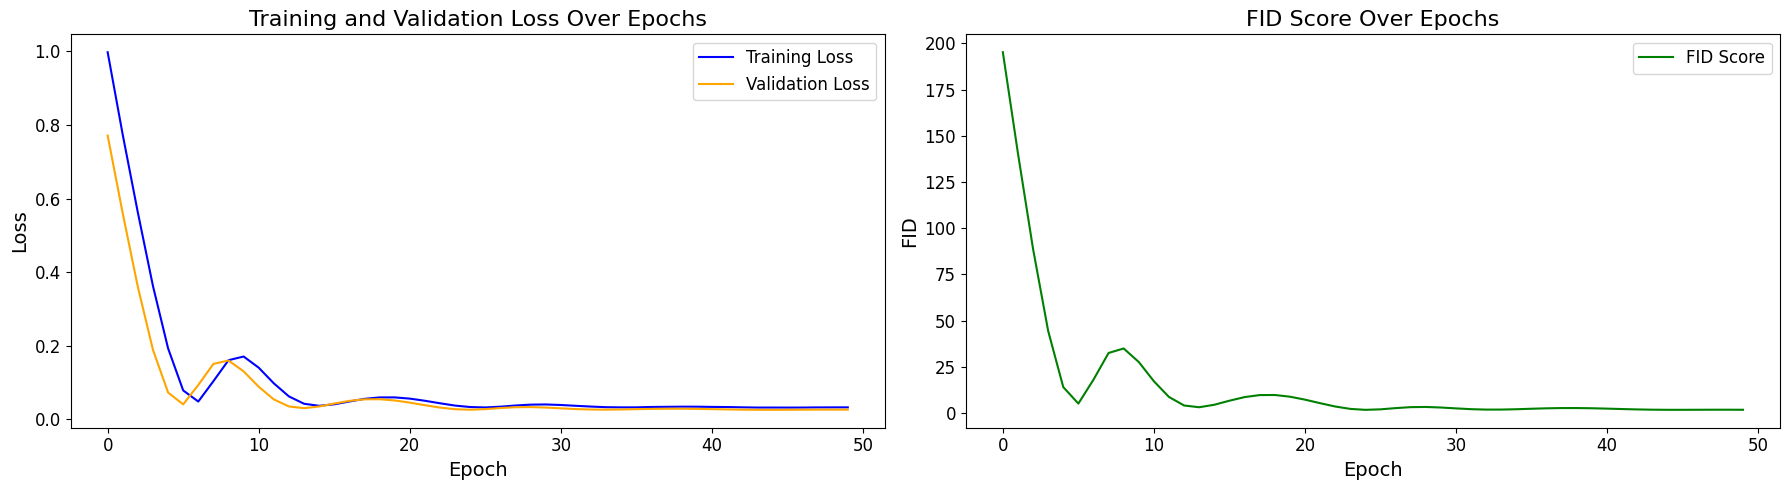

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy.linalg
import pennylane as qml

filename = "C:/Users/realc/OneDrive/Documents/GSOC/data/QG1_normalized_16_xl"
data_X = np.array(h5py.File(filename, "r")['X'])

num_samples = 10000
encoded_data = [angle_encoding(data_X, sample) for sample in range(num_samples)]
encoded_data = torch.tensor(np.array(encoded_data), dtype=torch.float32)
scrambled_states = apply_haar_scrambling(np.array(encoded_data), num_samples, seed=42)
scrambled_states = torch.tensor(scrambled_states, dtype=torch.float32)

train_encoded_data, val_encoded_data, train_scrambled_states, val_scrambled_states = train_test_split(
    encoded_data, scrambled_states, test_size=0.2, random_state=42, shuffle=True
)

n_qubits = 8
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface='torch')
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class QuantumLayer(nn.Module):
    def __init__(self, n_qubits, n_layers):
        super(QuantumLayer, self).__init__()
        weight_shapes = {"weights": (n_layers, n_qubits, 3)}
        self.qlayer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

    def forward(self, x):
        return self.qlayer(x)

class QuantumDiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_qubits, n_layers):
        super(QuantumDiffusionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, n_qubits)
        self.quantum_layer = QuantumLayer(n_qubits, n_layers)
        self.fc2 = nn.Linear(n_qubits, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.quantum_layer(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

def decode(encoded_data):
    num_samples, encoded_height, encoded_width, num_channels = encoded_data.shape
    decoded_data = np.zeros((num_samples, 16, 16))

    for sample in range(num_samples):
        for i in range(encoded_height):
            for j in range(encoded_width):
                for c in range(num_channels):
                    if c == 0:
                        decoded_data[sample, 2*i, 2*j] = encoded_data[sample, i, j, c]
                    elif c == 1:
                        decoded_data[sample, 2*i, 2*j+1] = encoded_data[sample, i, j, c]
                    elif c == 2:
                        decoded_data[sample, 2*i+1, 2*j] = encoded_data[sample, i, j, c]
                    elif c == 3:
                        decoded_data[sample, 2*i+1, 2*j+1] = encoded_data[sample, i, j, c]

    return decoded_data

def flip(decoded_data):
    return 1 - decoded_data

def calculate_statistics(data):
    data = data.reshape(data.shape[0], -1)
    mean = np.mean(data, axis=0)
    covariance = np.cov(data, rowvar=False)
    return mean, covariance

def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):
    diff = mu1 - mu2
    covmean, _ = scipy.linalg.sqrtm(sigma1 @ sigma2, disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff @ diff + np.trace(sigma1) + np.trace(sigma2) - 2 * np.trace(covmean)
    return fid

n_layers = 6
input_dim = 8 * 8 * 4 
hidden_dim = 128
output_dim = input_dim  

model = QuantumDiffusionModel(input_dim, hidden_dim, output_dim, n_qubits, n_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 50
loss_values = []
val_loss_values = []
fid_scores = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_scrambled_states.view(len(train_scrambled_states), -1))
    loss = criterion(outputs, train_encoded_data.view(len(train_encoded_data), -1))
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(val_scrambled_states.view(len(val_scrambled_states), -1))
        val_loss = criterion(val_outputs, val_encoded_data.view(len(val_encoded_data), -1))
        val_loss_values.append(val_loss.item())
        
        denoised_states = model(val_scrambled_states.view(len(val_scrambled_states), -1))
        denoised_states = denoised_states.view(len(val_scrambled_states), 8, 8, 4).detach().numpy()
        decoded_data = decode(denoised_states)
        decoded_data = flip(decoded_data)

        mu1, sigma1 = calculate_statistics(data_X[:len(decoded_data)])
        mu2, sigma2 = calculate_statistics(decoded_data)
        fid = calculate_fid(mu1, sigma1, mu2, sigma2)
        fid_scores.append(fid)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, FID: {fid:.4f}')

plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_values, label='Training Loss', color='blue')
plt.plot(val_loss_values, label='Validation Loss', color='orange')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Loss Over Epochs', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(fid_scores, label='FID Score', color='green')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('FID', fontsize=14)
plt.title('FID Score Over Epochs', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()


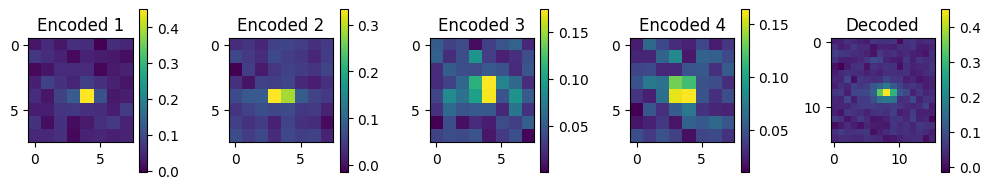

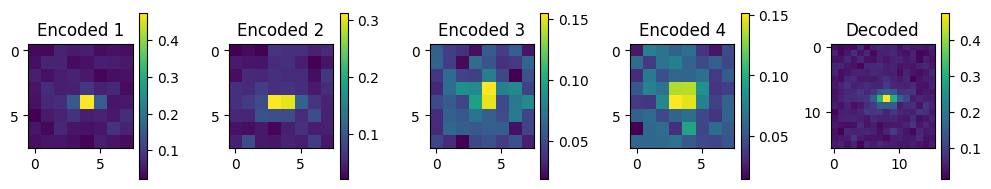

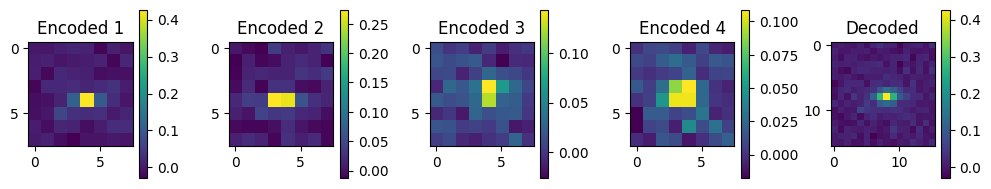

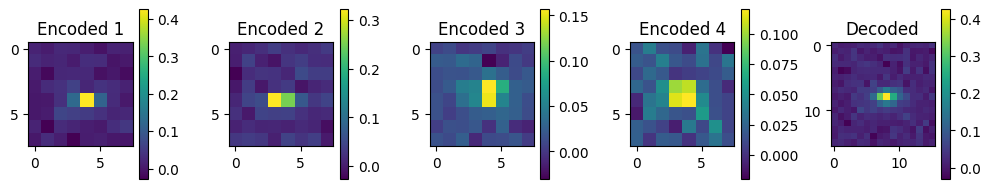

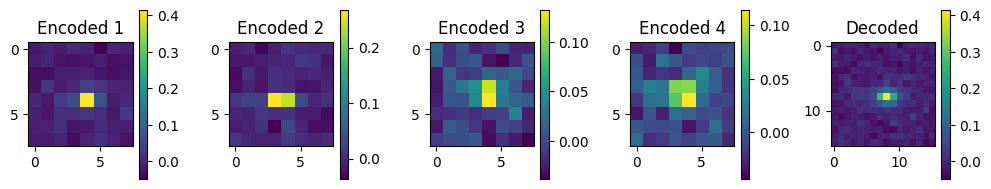

In [22]:
def generate_new_images(model, num_images, input_dim=8*8*4):
    model.eval()  
    with torch.no_grad():
        
        for i in range(num_images):
            random_noise = torch.randn(num_images, input_dim)
            
            generated_data = model(random_noise)
            generated_data = flip(generated_data.view(num_images, 8, 8, 4).detach().numpy())
            
            decoded_images = decode(generated_data)
            fig, axes = plt.subplots(1, 5, figsize=(10, 2))

            for qubit in range(4):
                im = axes[qubit].imshow(generated_data[i, :, :, qubit], cmap='viridis')
                axes[qubit].set_title(f"Encoded {qubit+1}")
                fig.colorbar(im, ax=axes[qubit])

            im = axes[4].imshow(decoded_images[i], cmap='viridis')
            axes[4].set_title("Decoded")
            fig.colorbar(im, ax=axes[4])
            
            plt.tight_layout()
            plt.show()

    return decoded_images

num_samples_to_generate = 5
new_images = generate_new_images(model, num_samples_to_generate)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3841648..2.500553].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.5134242..3.6954513].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.1169674..2.1689687].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.262063..3.1282256].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.642807..2.766878].


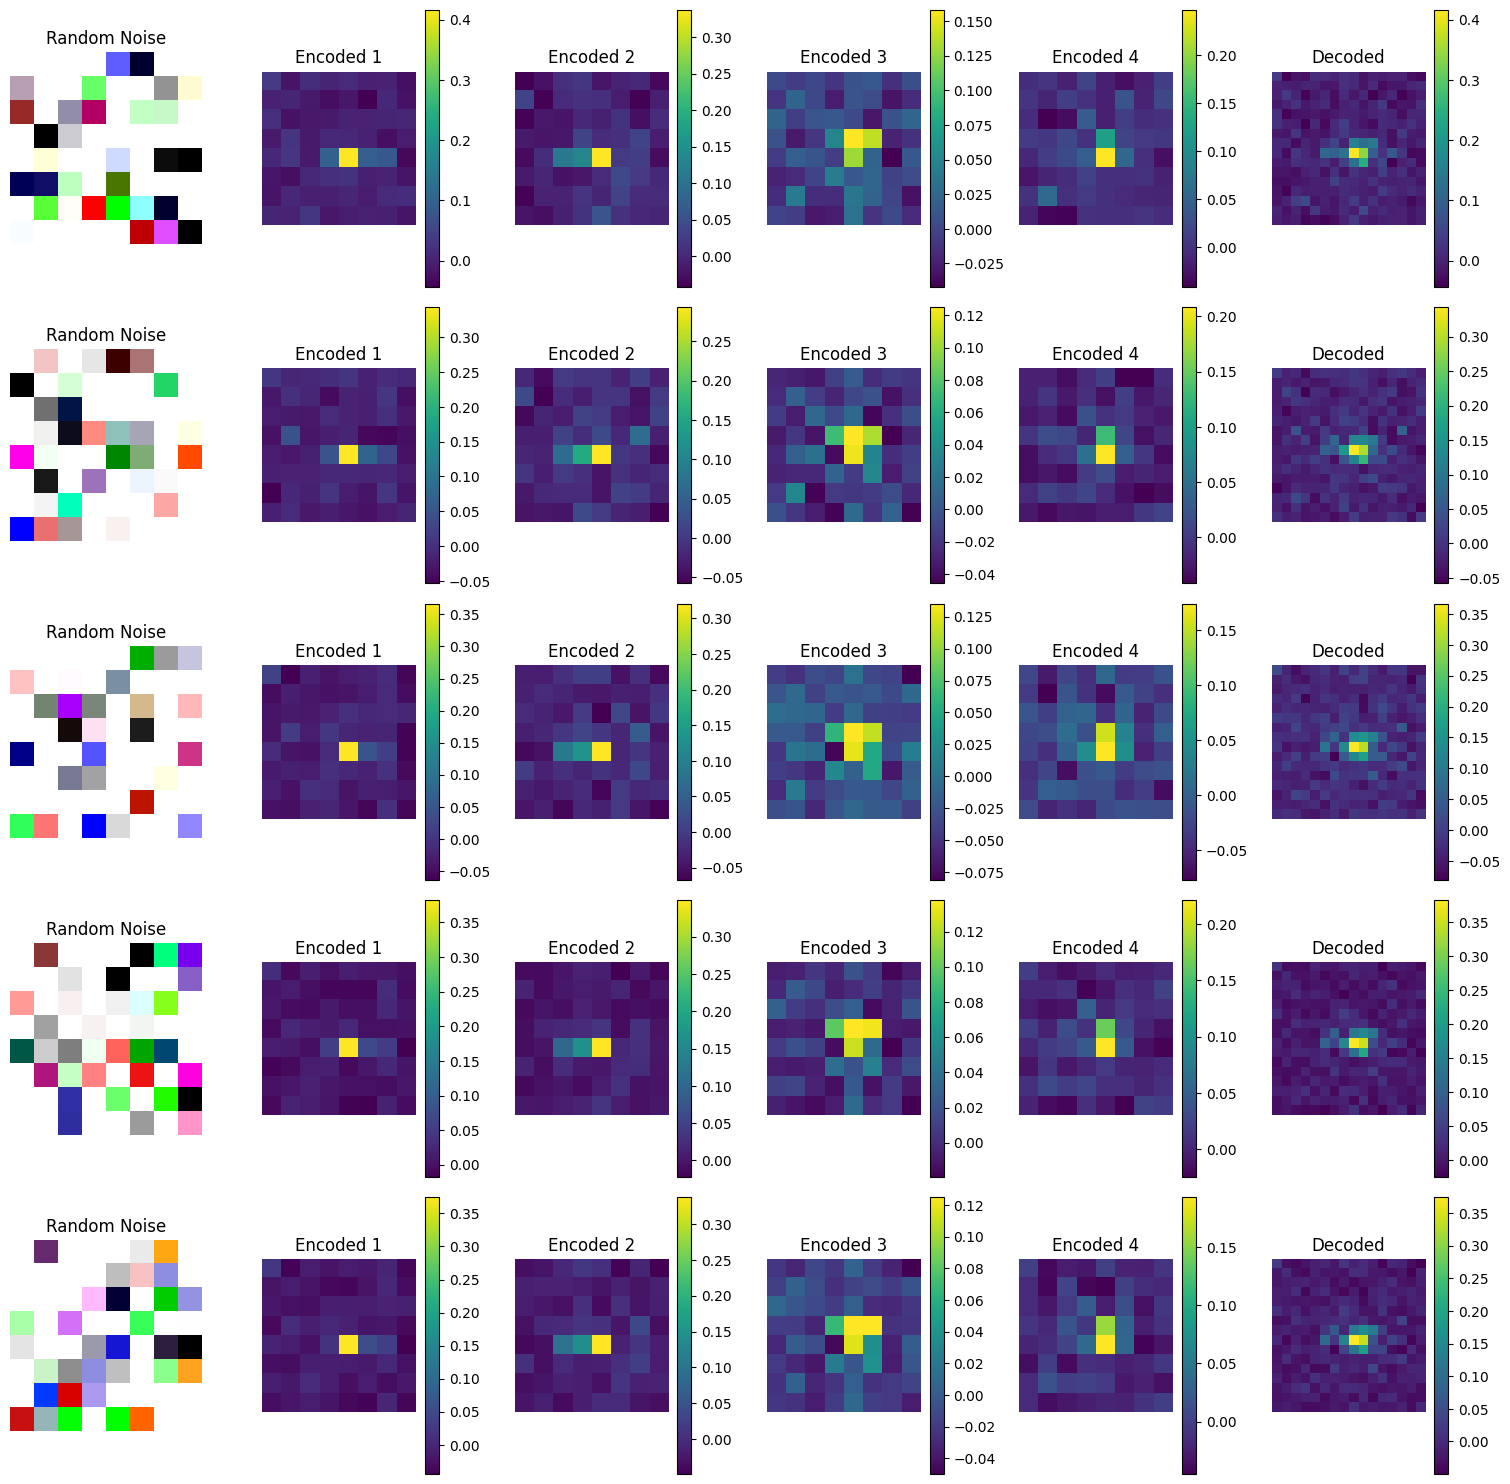

In [14]:
import matplotlib.pyplot as plt
import torch

def generate_new_images(model, num_images, input_dim=8*8*4):
    model.eval()  
    with torch.no_grad():
        fig, axes = plt.subplots(num_images, 6, figsize=(15, 3*num_images))  # Adjust figure size based on num_images
        
        for i in range(num_images):
            random_noise = torch.randn(1, input_dim)  # Single image of noise
            generated_data = model(random_noise)
            generated_data = flip(generated_data.view(1, 8, 8, 4).detach().numpy())
            decoded_images = decode(generated_data)
            
            # Plot random noise
            axes[i, 0].imshow(random_noise.view(8, 8, 4).numpy(), cmap='viridis')
            axes[i, 0].set_title("Random Noise")
            axes[i, 0].axis('off')
            
            # Plot generated images
            for qubit in range(4):
                im = axes[i, qubit + 1].imshow(generated_data[0, :, :, qubit], cmap='viridis')
                axes[i, qubit + 1].set_title(f"Encoded {qubit+1}")
                axes[i, qubit + 1].axis('off')
                fig.colorbar(im, ax=axes[i, qubit + 1])
            
            # Plot decoded image
            im = axes[i, 5].imshow(decoded_images[0], cmap='viridis')
            axes[i, 5].set_title("Decoded")
            axes[i, 5].axis('off')
            fig.colorbar(im, ax=axes[i, 5])

        plt.tight_layout()
        plt.show()

    return decoded_images

num_samples_to_generate = 5
new_images = generate_new_images(model, num_samples_to_generate)
